## Analyze and build model identify value Nth-percentile latency base on Buckets Histogram

**_Appendix:_**

- Load raw data from file
- Standardize and cleaning data
- Plot data growth with buckets latency
	+ Understand chart
- Analyze growth data
	+ Analysis growth buckets ratio at timestamp
	+ Identify growth on buckets on timeline for calculate percentile latency
- Calculate Nth-percentile latency
	+ Linear Interpolation
	+ Linear Interpolation for dataset
	+ Conclude the result

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.options.mode.chained_assignment = None

In [49]:
DATA = []
BUCKETS = [0, 0.05, 0.1, 0.25, 0.5, 1, 1.5, 2, np.Inf]

### Load raw data from file

In [50]:
import json

def get_data_from_file(filename: str):
    f = open(filename, "r")
    data = []
    while True:
        line = f.readline()
        if not line:
            break
        # Standardlize json to dict
        row = json.loads(line)
        # Append to Array
        data.append(row)
    return data

In [51]:
data = get_data_from_file("../statics/requests.json")
raw_df = pd.DataFrame(columns=['timestamp', "request_id", 'duration_time'], data=data)

Bước dưới đây thực hiện bucketing dữ liệu về requests có chưa duration_time vào các bucket latency đã được quy định trước tương đồng với định dạng metrics lưu trữ trên Prometheus có suffix **_bucket**

In [52]:
from datetime import datetime
from typing import Dict

# Bucketing
def bucketing(duration_time):
    res = []
    for bucket in BUCKETS:
        if duration_time <= bucket:
            res.append(bucket)
    return res

raw_df["buckets"] = raw_df["duration_time"].apply(lambda x: bucketing(x))
data = []
def bins_value(row, bins_dict: Dict):
    # unwind data from list
    buckets = row['buckets']
    for le in buckets:
        if le in bins_dict:
            bins_dict[le] += 1
    bins_series = pd.Series(
        data=bins_dict, index=bins_dict.keys()  # type: ignore
    )
    # Join two series
    new_row = pd.concat([row, bins_series])
    data.append(new_row.to_dict())
    return new_row

bins_dict = {k: 0 for k in BUCKETS}
raw_df.apply(lambda x: bins_value(x, bins_dict), axis=1)
bucket_df = pd.DataFrame(data=data).drop(columns=['buckets', 'request_id', 'duration_time'])


### Standardize and cleaning data

In [53]:
# Re format timestamp to  "%d/%m/%Y, %H:%M:%S"
bucket_df['timestamp'] = bucket_df['timestamp'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y, %H:%M:%S"))
bucket_df['timestamp'] = pd.to_datetime(bucket_df["timestamp"], unit="ms", utc=True).map(lambda x: x.tz_convert('Asia/Ho_Chi_Minh')).apply(lambda x: x.minute)
print("Bucket dataset (Prometheus _bucket suffix):")
display(bucket_df)

Bucket dataset (Prometheus _bucket suffix):


,timestamp,0.0,0.05,0.1,0.25,0.5,1.0,1.5,2.0,inf
0,0,0,0,0,0,1,1,1,1,1
1,5,0,0,0,0,2,2,2,2,2
2,10,0,0,0,0,3,3,3,3,3
3,15,0,0,0,0,3,3,4,4,4
4,20,0,0,0,0,3,4,5,5,5
5,25,0,0,0,0,3,5,6,6,6
6,30,0,0,0,0,3,5,6,7,7
7,35,0,0,0,1,4,6,7,8,8
8,40,0,0,1,2,5,7,8,9,9
9,45,0,0,1,2,5,7,9,10,10


### Plot data growth with buckets latency

Thực hiện biểu diễn những giá trị lên biểu đồ:

<Axes: xlabel='timestamp'>

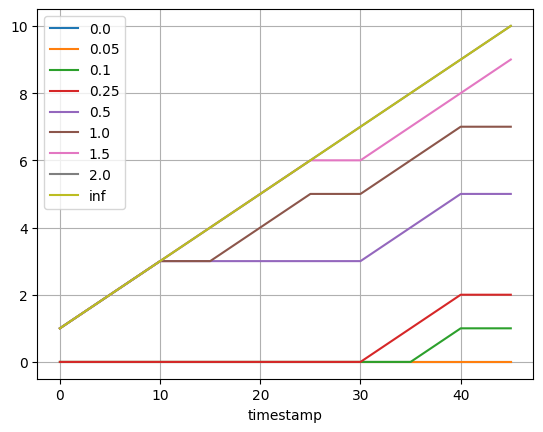

In [54]:
bucket_df.plot(x="timestamp", grid=True)

#### Understand chart

Xét tại 1 thời điểm t = 10 (minutes):

    - Bucket le=0 bao gồm 0 request đã được fill vào
    - Bucket le=0.05 bao gồm 0 request đã được fill vào
    - Bucket le=0.1 bao gồm 0 request đã được fill vào
    - Bucket le=0.25 bao gồm 0 requests đã được fill vào
    - Bucket le=0.5 có 3 requests đã được fill vào
    - Bucket le=1.0 có 3 requests đã được fill vào
    - Bucket le=2.0 có 3 requests đã được fill vào
    - Bucket le=inf có 3 requests đã được fill vào
    
Vì vậy, Trong khoảng thời gian t = 5 số request tăng trưởng theo mỗi bucket được tăng như sau:

- Bucket range [0 -> 0.05] tăng: 
$\Delta$ v = 0 - 0 = 0 => không có sự tăng trưởng, vì vậy không có requests nào rơi vào khoảng này
- Bucket range [0.05 -> 0.1] tăng: 
$\Delta$ v = 0 - 0 = 0 => không có sự tăng trưởng, vì vậy không có requests nào rơi vào khoảng này
- Bucket range [0.1 -> 0.25] tăng: 
$\Delta$ v = 0 - 0 = 0 => không có sự tăng trưởng, vì vậy không có requests nào rơi vào khoảng này
- Bucket range [0.25 -> 0.5] tăng: 
$\Delta$ v = 3 - 0 = 3 => Có 3 request nằm trong khoảng này

...

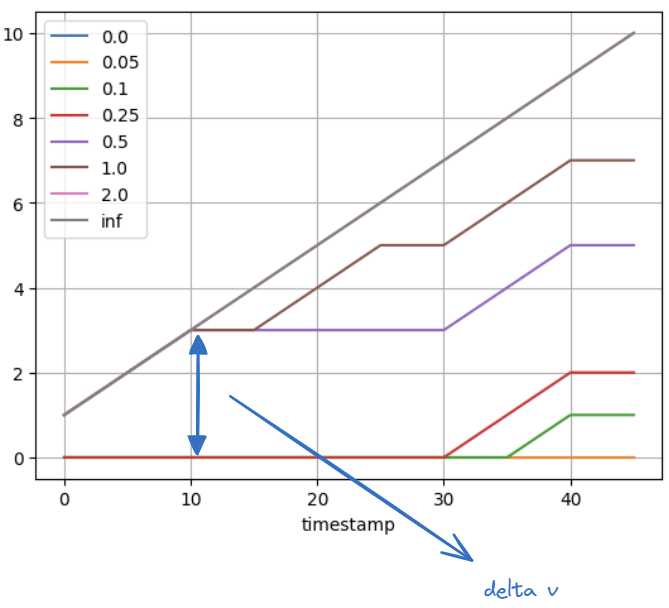



### Analyze growth data

#### Analysis growth buckets ratio at timestamp

Đây là thuật toán mà Prometheus sử dụng để tính toán tỉ lệ tăng trưởng tại các buckets theo dòng thời gian. Vì histogram được sử dụng trong Prometheus phân chia bucket range start từ 0 nên counter của các bucket lớn hơn sẽ bao gồm cả counter của bucket nhỏ hơn. (Buckets: 0->0.025, 0->0.05, -> 0->0.1)

_Ví dụ: Bucket **le=+Inf** sẽ bao gồm phần tử của **le=0.5 và le=0.25** hoặc bucket **le=0.5** bao gồm các phần tử của bucket **le=0.25**_

**Vậy nên, khi biểu diễn các buckets trên biểu đồ thì các giá trị của bucket nhỏ hơn sẽ không bao giờ vượt quá ngưỡng giá trị của các bucket lớn hơn tại một thời điểm**

Tham khảo thêm: https://prometheus.io/docs/tutorials/understanding_metric_types/#histogram

#### Identify growth on buckets on timeline for calculate percentile latency

Để xét tăng trưởng của bucket theo dòng thời gian, dựa vào biểu đồ trên thì thực hiện xét điểm dữ liệu hiện tại so với điểm dữ liệu trước đó, bucket nào có độ dốc nhiều hơn thì dữ liệu sẽ biến động nhiều hơn ở bucket đó.

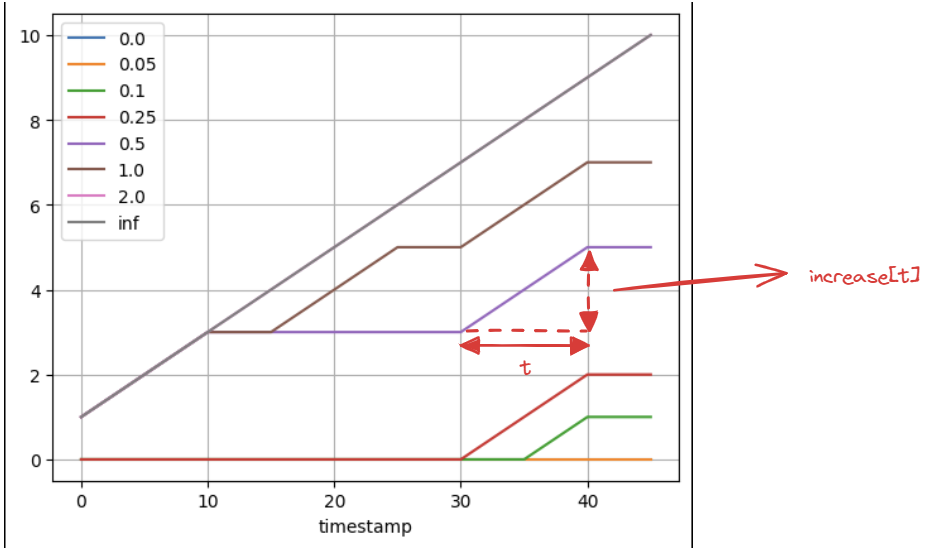

Từ biểu đồ trên có thể suy ra công thức tính tăng trưởng dữ liệu tại thời điểm  **t** sau mỗi khoảng $\Delta$ t:

**increase[t] = v[t] - v[t - $\Delta$ t]**

Đây là công thức được Prometheus sử dụng để tính giá trị tăng trưởng giữa các khoảng thời gian. Chi tiết xem tại: https://prometheus.io/docs/prometheus/latest/querying/functions/#increase


Từ đó suy ra được công thức tính tỉ lệ tăng trưởng trung bình:

_Vì các time interval input là đa dạng (m,s,h,d) nên Prometheus lấy đơn vị thời gian nhỏ nhất là second để tính giá trị trung bình_

**_Công thức tính tỉ lệ tăng trưởng trung bình tại thời điểm **t** sau mỗi khoảng $\Delta$ t:_**

**rate[t] = (v[t] - v[t - $\Delta$ t]) / t**

<u>Ví dụ: rate[5m] = (v[t] - v[t - 5m]) / (5 * 60)</u>

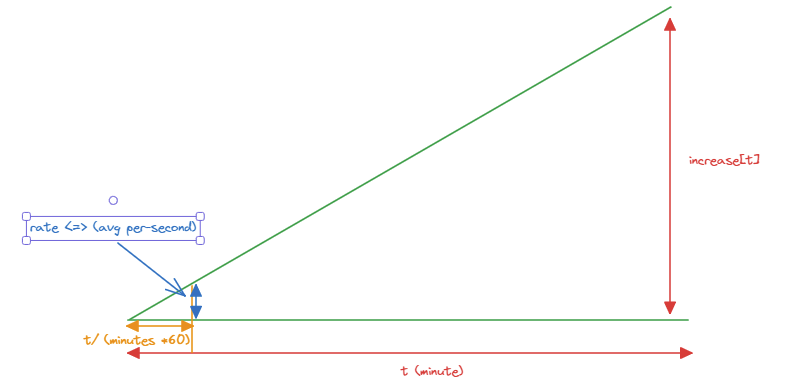

Hình vẽ trên mô tả trong khoảng thời gian t thì tăng trưởng **increse[t]** -> mỗi 1s thì sẽ tăng trưởng **increse[t]/(t * 60) = rate** 

In [55]:
bucket_df.head()

,timestamp,0.0,0.05,0.1,0.25,0.5,1.0,1.5,2.0,inf
0,0,0,0,0,0,1,1,1,1,1
1,5,0,0,0,0,2,2,2,2,2
2,10,0,0,0,0,3,3,3,3,3
3,15,0,0,0,0,3,3,4,4,4
4,20,0,0,0,0,3,4,5,5,5


In [56]:

# Calculate rate(5m)
first_row = bucket_df.iloc[0].to_dict()
bucket_df_rate = bucket_df.set_index('timestamp')[BUCKETS].diff().fillna(first_row) / (5 * 60)
display(bucket_df_rate.head())

,0.0,0.05,0.1,0.25,0.5,1.0,1.5,2.0,inf
timestamp,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.003333,0.003333,0.003333,0.003333,0.003333
5,0.0,0.0,0.0,0.0,0.003333,0.003333,0.003333,0.003333,0.003333
10,0.0,0.0,0.0,0.0,0.003333,0.003333,0.003333,0.003333,0.003333
15,0.0,0.0,0.0,0.0,0.000000,0.000000,0.003333,0.003333,0.003333
20,0.0,0.0,0.0,0.0,0.000000,0.003333,0.003333,0.003333,0.003333


_Khi đã xác định được mức độ tăng trưởng của buckets tại một thời điểm, lúc này sẽ có thể xác định được giá trị latency percentile dựa vào giá trị tăng trưởng trung bình (rate). Ví dụ, khi muốn tính toán 95th latency percentile nghĩa là sẽ tìm ra bucket range có 95% requests rơi vào._

----

### Calculate Nth-percentile latency

Vì histogram buckets của Prometheus có điểm start range bucket luôn luôn là 0 nên giá trị của bucket lớn nhất cũng sẽ bao gồm những giá trị của bucket nhỏ hơn. Lúc này, giá trị tăng trưởng trung bình của bucket lớn nhất tại 1 thời điểm (trong trưởng hợp này là +Inf) sẽ là giá trị **n**

**_Ví dụ: Tính 95th percentile latency tại thời điểm t=15:_**

Tỉ lệ tăng trưởng của buckets tại thời điểm t=15:
```
bucket: 0.0	    0.05	0.1	    0.25	0.5	        1.0	        1.5	        2.0	        inf
rate:   0.0	    0.0	    0.0	    0.0	    0.000000	0.000000	0.003333	0.003333	0.003333
```
=>
```
p = 0.95
N = 0.003333
-> rank = N * P = 0.00316635
```
Sau khi xác định được rank, thực hiện tìm khoảng rate có chứa rank.
```
-> Tìm được range rate: 0.000000 -> 0.003333. Và khoảng rate này nằm trong bucket range: 1.0 -> 1.5
-> Bucket range mà 95% requests rơi vào: [1.0 -> 1.5]

```
Khi đã xác định được bucket range. Muốn tính giá trị latency mà xử lý hầu hết được 95% request tại khoảng thời gian đó thì thực hiện phép nội suy (Linear Interpolation) để tìm được giá trị latency dựa vào bucket range và rate đã biết.

#### Linear Interpolation

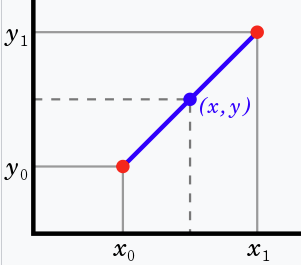

Điểm (x, y) là giá trị nội suy tính toán được.

Công thức nội suy:

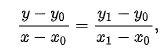

-> Áp dụng nội suy:

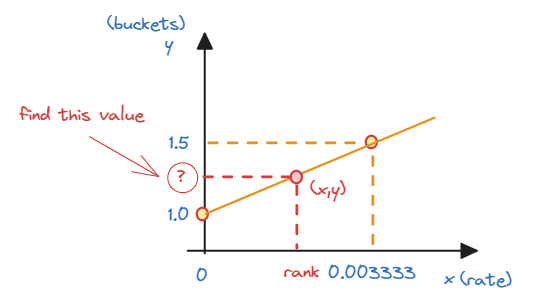

```
=> y = (((y1-y0)*(x - x0)) / (x1 - x0)) + y0
=> y = 1.475
```
Kết quả tính ra được y = 1.475, kết quả này gần sát với giá trị thực tế là 1.422

Đây là kết quả nội suy để tính được giá trị latency tại phân vị thứ 95 từ buckets histogram (không bao gồm thuộc tính **duration_time**). Việc lưu thông tin về request liên quan đến latency sử dụng các buckets để thống kê giúp cho việc giảm thiểu tài nguyên lưu trữ thay vì lưu lại duration_time cho mỗi request cụ thể. Vì vậy nó giúp cho việc overview tình trạng latency service hiệu quả hơn (dễ dàng overview bằng histogram). Tuy nhiên, sẽ phải đánh đổi về độ chính xác của metrics, đặc biệt là khi có những request có latency cực cao hoặc cực thấp thì histogram sẽ không phản ánh rõ được điều đó.

Các bước tính latency Nth value dựa vào histogram buckets:
- Calculate rate()
- Calculate percentile Nth
```
<-> Prometheus formula: histogram_quantile(0.95, sum(rate(http_request_duration_seconds_bucket[5m])) by (buckets))
```

In [57]:
display(bucket_df_rate)

,0.0,0.05,0.1,0.25,0.5,1.0,1.5,2.0,inf
timestamp,,,,,,,,,
0,0.0,0.0,0.000000,0.000000,0.003333,0.003333,0.003333,0.003333,0.003333
5,0.0,0.0,0.000000,0.000000,0.003333,0.003333,0.003333,0.003333,0.003333
10,0.0,0.0,0.000000,0.000000,0.003333,0.003333,0.003333,0.003333,0.003333
15,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.003333,0.003333,0.003333
20,0.0,0.0,0.000000,0.000000,0.000000,0.003333,0.003333,0.003333,0.003333
25,0.0,0.0,0.000000,0.000000,0.000000,0.003333,0.003333,0.003333,0.003333
30,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003333,0.003333
35,0.0,0.0,0.000000,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333
40,0.0,0.0,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333


#### Linear Interpolation for dataset

In [58]:
def histogram_percentile(percentiles: float, row: pd.Series):
    count = row[np.Inf]
    rank = count * percentiles
    row_diff = row.diff()
    row_diff.fillna(0, inplace=True)
    count, upper, lower = 0, 0, 0
    stack = []
    for bucket, val in row_diff.items():
        count = count + val
        el = dict(
            bucket=bucket,
            rate=val
        )
        if len(stack) == 0:
            # Add first value
            stack.append(el)
            lower, upper = el, el
            continue
        lower = stack[-1]
        upper = el
        stack.append(el)
        if count >= rank:
            break
    # Using Linear interpolation
    y0, y1 = lower['bucket'], upper['bucket']
    x0, x1 = lower['rate'], upper['rate']
    x = rank
    return (((y1-y0)*(x - x0)) / (x1 - x0)) + y0


hist_per = bucket_df_rate.apply(lambda x: histogram_percentile(
    percentiles=0.95, row=x), axis=1)
hist_per = hist_per.to_frame(name="95th")
duration_time_row = raw_df['duration_time'].to_numpy()
hist_per['duration_time'] = duration_time_row

display(hist_per)

,95th,duration_time
timestamp,,
0,0.4875,0.427
5,0.4875,0.275
10,0.4875,0.400
15,1.4750,1.422
20,0.9750,0.759
25,0.9750,0.689
30,1.9750,1.618
35,0.2425,0.124
40,0.0975,0.055


#### Conclude the result
Kết quả trên cho thấy có độ lệch tương đối so với **duration_time** thực tế, nguyên nhân ở do việc chia các buckets. Vì khi thực hiện nội suy sẽ đưa ra kết quả trong khoảng 2 điểm đã biết, vì vậy nếu 2 điểm đã biết có khoảng cách càng xa nhau thì kết quả nội suy được sẽ bị lệch tương đối nhiều. Vì vậy, thực hiện chia nhỏ buckets thành các đoạn nhỏ hơn sẽ cho ra những kết quả chính xác với thực tế hơn.

Tuy nhiên, cũng tùy thuộc vào yêu cầu để chia nhỏ các buckets như thế nào cho hợp lý. Ví dụ để thống kê SLO latency thì sẽ cần it nhất những buckets bao gồm giá trị SLO được đặt ra latency.

Ví dụ: SLO latency:

- 99% requests <= 500 ms
- 95% requests <= 450 ms
- 50% requests <= 200 ms

-> Cần buckets [0, 200ms, 450ms, 500ms, +inf]